In [1]:
# set auto-reload of the notebook
%load_ext autoreload
%autoreload 2

import cns
import cns.data_utils as cdu
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
# set color_map to tab10
color_map = plt.cm.get_cmap('tab10').colors[:10]
plt.rcParams.update({'font.size': 12})

C:\Users\adams\AppData\Local\Temp\ipykernel_51536\1736925853.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10').colors[:10]


In [2]:
cns_dfs = {}
for grouping in ["arms", "20MB", "5MB", "1MB", "250KB"]:
	print(f"Loading {grouping}...")
	samples_df, cns_df = cdu.main_load(grouping)
	cns.only_aut(cns_df, inplace=True)
	cns.add_total_cn(cns_df, inplace=True)
	cns_dfs[grouping] = cns_df
samples_df["type"].value_counts().head()

Loading arms...
Loading 20MB...
Loading 5MB...
Loading 1MB...
Loading 250KB...


type
LUAD    1314
BRCA    1157
LUSC     996
OV       618
PRAD     563
Name: count, dtype: int64

In [3]:
cosmic = cdu.load_COSMIC()
cosmic_df = cns.segments_to_cns_df(cosmic)[["chrom", "start", "end", "name"]].rename(columns={"name": "gene"})
ensembl = cdu.load_ENSEMBL()
cancer_type = "LUSC"
val_count = 3

In [9]:
def get_grouping_name(grouping):
    if grouping == "whole":
        return "Whole genome"
    elif grouping == "arms":
        return "Chromosomal arms"
    elif grouping.upper().endswith("MB") or grouping.upper().endswith("KB"):
        # Extract number and unit
        try:
            number = int(grouping[:-2])
            unit = grouping[-2:].upper()
            return f"{number} {unit.capitalize()} bins"
        except ValueError:
            pass  # Fall through to error
    raise ValueError(f"Unknown grouping: {grouping}")

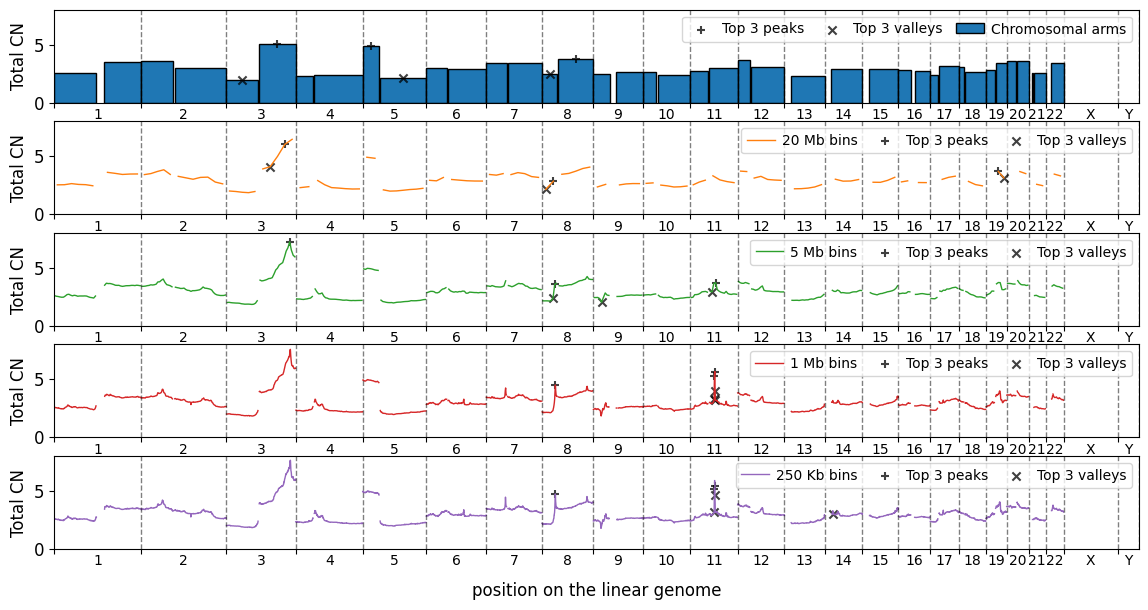

In [10]:
fig, axs = plt.subplots(len(cns_dfs), 1, figsize=(14, 7))

for i, (grouping, cns_df) in enumerate(cns_dfs.items()):
	sel_df = cns.select_cns_by_type(cns_df, samples_df, cancer_type) if cancer_type != "all" else cns_df
	group_df = cns.group_samples(cns.only_aut(cns.add_total_cn(sel_df)))
	group_df["sample_id"] = f"mean {cancer_type} CN"
	group_df = cns.add_cum_mid(group_df)
	if grouping == "whole":
		group_by = "sample"
	elif grouping == "arms":
		group_by = "chrom"
	else:
		group_by = "cons"
	group_df["score"] = cns.calc_angles(group_df, "total_cn", group_by=group_by)

	if grouping == "whole" or grouping == "arms":

		cns.plot_bars(axs[i], group_df, cn_column="total_cn", color=color_map[i], label=f"{get_grouping_name(grouping)}")
	else:
		cns.plot_lines(axs[i], group_df, cn_column="total_cn", color=color_map[i],  label=f"{get_grouping_name(grouping)}")
	cns.plot_x_lines(axs[i])
	cns.plot_x_ticks(axs[i])

	group_df = group_df.sort_values(by="score", ascending=False)
	axs[i].scatter(group_df["cum_mid"].head(val_count), group_df["total_cn"].head(val_count), color="k", alpha=0.75, s=35, label=f"Top {val_count} peaks", marker="+")
	axs[i].scatter(group_df["cum_mid"].tail(val_count), group_df["total_cn"].tail(val_count), color="k", alpha=0.75, s=35, label=f"Top {val_count} valleys", marker="x")
	axs[i].set_ylim(0, 8)
	axs[i].set_ylabel("Total CN")
	axs[i].legend(loc="upper right", ncol=3, fontsize=10, handletextpad=0.5, columnspacing=1)

axs[-1].set_xlabel("position on the linear genome")

cdu.save_cns_fig(f"fig_peaks_valleys_{cancer_type}")

In [5]:
score_means = []

def get_gouping_type(bins):
	if bins == "whole":
		return "sample"
	elif bins == "arms":
		return "chrom"
	else:
		return "cons"

for i, (grouping, cns_df) in enumerate(cns_dfs.items()):
	print(f"Loading {grouping}...")
	sel_df = cns.select_cns_by_type(cns_df, samples_df, cancer_type) if cancer_type != "all" else cns_df
	sel_df = cns.group_samples(cns.only_aut(cns.add_total_cn(sel_df)))
	sel_df["sample_id"] = f"mean {cancer_type} CN"
	sel_df["score"] = cns.calc_angles(sel_df, "total_cn", get_gouping_type(grouping))	
	score_means.append(cns.mean_value_per_seg(sel_df, ensembl, "score"))

mean_dfs = {}
mean_df = score_means[0].copy()
for vals in score_means[1:]:
	mean_df["score"] += vals["score"]
mean_df["score"] /= len(score_means)
mean_df["total_cn"] = cns.mean_value_per_seg(sel_df, ensembl, "total_cn")["total_cn"]
mean_df = pd.merge(mean_df, cosmic_df, how="left")

cns.save_cns(mean_df, cdu.pjoin(cdu.out_path, f"gene_scores_{cancer_type}.tsv"))

Loading arms...
Loading 20MB...
Loading 5MB...
Loading 1MB...
Loading 250KB...


In [6]:
print(mean_df[~mean_df["gene"].isna()].sort_values(by="score", ascending=False).head(10))

       chrom      start        end             name     score  total_cn  \
14166   chr3  181429713  181432221  ENSG00000181449  1.028664  7.500447   
14152   chr3  178865901  178957881  ENSG00000121879  0.959129  6.923450   
14117   chr3  168801286  169381406  ENSG00000085276  0.791155  6.360487   
3698   chr11   70049268   70053496  ENSG00000168040  0.699678  5.679763   
14149   chr3  176737142  176915261  ENSG00000177565  0.681502  6.779477   
14266   chr3  195754053  195809060  ENSG00000072274  0.675650  5.966429   
14234   chr3  189349204  189615068  ENSG00000073282  0.670609  6.186544   
14086   chr3  158288951  158325041  ENSG00000178053  0.656166  5.379615   
14264   chr3  195473635  195539148  ENSG00000145113  0.653499  5.897417   
14230   chr3  187439164  187463515  ENSG00000113916  0.642138  6.163825   

          gene  
14166     SOX2  
14152   PIK3CA  
14117    MECOM  
3698      FADD  
14149  TBL1XR1  
14266     TFRC  
14234     TP63  
14086     MLF1  
14264     MUC4  
1423

In [7]:
print(mean_df.sort_values(by="score", ascending=False).head(10))

      chrom      start        end             name     score  total_cn  gene
14170  chr3  182840000  182881627  ENSG00000078081  1.095665  7.582006   NaN
14169  chr3  182733005  182833863  ENSG00000078070  1.095665  7.582006   NaN
14168  chr3  182655861  182703741  ENSG00000043093  1.076511  7.615319   NaN
14167  chr3  182511287  182639423  ENSG00000058063  1.076511  7.615319   NaN
14172  chr3  182971031  183016292  ENSG00000176597  1.052330  7.370692   NaN
14166  chr3  181429713  181432221  ENSG00000181449  1.028664  7.500447  SOX2
14171  chr3  182895830  183146566  ENSG00000053524  0.966251  7.431953   NaN
14154  chr3  179040778  179053323  ENSG00000121864  0.963805  6.928036   NaN
14153  chr3  178957529  178984790  ENSG00000171121  0.961641  6.925914   NaN
14155  chr3  179065479  179112719  ENSG00000171109  0.959944  6.928036   NaN


We therefore focused on relative effects: when applied to the COSMIC gene set (i.e. where cancer effect is already expected), our method determines the top 5 genes to be FADD (OS=1.53), CCND1 (OS=1.22), FGFR1 (OS=0.94), SOX2 (OS=0.65), and EGFR (OS=0.46). 

In [8]:

ordered_df = mean_df.sort_values(by=["score"], ascending=False)
ordered_df["score"].sum()
tsgs_df = ordered_df.query("score < 0")[["chrom", "start", "end", "name", "score"]].copy()
tsgs_df["score"] = -tsgs_df["score"]
print(tsgs_df["score"].describe())
print(tsgs_df["score"].sum())
tsgs_df.to_csv(cdu.pjoin(cdu.out_path, f"tsgs_cnsistent_all.tsv"), sep="\t", index=False, header=False)
tsgs_df[-1000:].to_csv(cdu.pjoin(cdu.out_path, f"tsgs_cnsistent_1000.tsv"), sep="\t", index=False, header=False)

ogs_df = ordered_df.query("score >= 0")[["chrom", "start", "end", "name", "score"]].copy()
print(ogs_df["score"].describe())
print(ogs_df["score"].sum())
# ogs_df["score"] = ogs_df["score"] / ogs_df["score"].sum() * tsgs_df["score"].sum()
# print(ogs_df["score"].describe())
# print(ogs_df["score"].sum())
ogs_df.to_csv(cdu.pjoin(cdu.out_path, f"ogs_cnsistent_all.tsv"), sep="\t", index=False, header=False)
ogs_df[:1000].to_csv(cdu.pjoin(cdu.out_path, f"ogs_cnsistent_1000.tsv"), sep="\t", index=False, header=False)

count    10887.000000
mean         0.136678
std          0.167886
min          0.000069
25%          0.029303
50%          0.075055
75%          0.151642
max          0.649766
Name: score, dtype: float64
1488.0116215720113
count    8543.000000
mean        0.141128
std         0.162065
min         0.000035
25%         0.028358
50%         0.090398
75%         0.182476
max         1.095665
Name: score, dtype: float64
1205.6524116669875
